In [1]:
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC, SVC

In [2]:
import seaborn as sns

In [49]:
def evaluate(clf):
    clf.fit(X_train, y_train)
    print('Train acc: {0:.4f}'.format(accuracy_score(y_train, clf.predict(X_train))))
    print('Test acc: {0:.4f}'.format(accuracy_score(y_test, clf.predict(X_test))))
    
    print('Train f1: {0:.4f}'.format(f1_score(y_train, clf.predict(X_train), average='weighted')))
    print('Test f1: {0:.4f}'.format(f1_score(y_test, clf.predict(X_test), average='weighted')))
    
    print(classification_report(y_test, clf.predict(X_test)))

In [50]:
def acc(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    return accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, clf.predict(X_test))

In [3]:
DIR = '../../data/processed/snopes'

In [4]:
crawls = glob.glob('{}/media_*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df = pd.read_csv(last_crawl)

In [5]:
crawls = glob.glob('{}/media_*.csv'.format('../../data/processed/reuters'))
last_crawl = sorted(crawls)[-1]
df_r = pd.read_csv(last_crawl)

In [ ]:
df['total_count_new'] = df.total_count-df.invalid_count

In [28]:
(df.known_count/(df.total_count-df.invalid_count+1)).describe()

count    838.000000
mean       0.129125
std        0.287840
min        0.000000
25%        0.000000
50%        0.020000
75%        0.080000
max        1.000000
dtype: float64

In [29]:
(df_r.known_count/(df_r.total_count-df_r.invalid_count+1)).describe()

count    395.000000
mean       0.255964
std        0.195584
min        0.000000
25%        0.109903
50%        0.212121
75%        0.355556
max        1.000000
dtype: float64

[Text(0, 0.5, 'Percent known URLs'),
 [Text(0, 0, 'Snopes'), Text(0, 0, 'Reuters')],
 Text(0.5, 0, 'Dataset')]

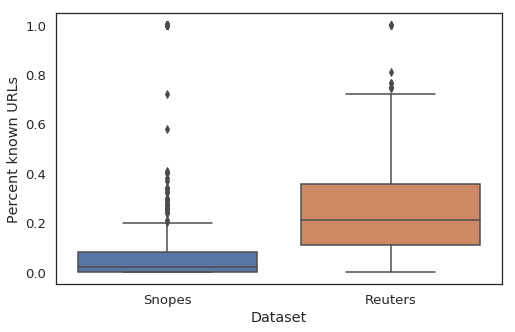

In [31]:
sns.boxplot(data=[(df.known_count/(df.total_count-df.invalid_count+1)), 
                  (df_r.known_count/(df_r.total_count-df_r.invalid_count+1))]).set(
    xlabel='Dataset', 
    ylabel='Percent known URLs',
    xticklabels=['Snopes', 'Reuters']
)

In [22]:
df_r.known_count.describe()

count    395.000000
mean      11.093671
std        8.617585
min        0.000000
25%        5.000000
50%        9.000000
75%       16.000000
max       39.000000
Name: known_count, dtype: float64

In [6]:
df = df[df.label!='mixture']
df = df[~df.claim.str.contains('video',regex=False, case=False)]

In [7]:
df.shape

(838, 15)

In [4]:
last_crawl

'../../data/processed/snopes/media_2019-02-02 15:59:21.csv'

In [24]:
sns.set_style("whitegrid")

In [12]:
sns.set(rc={'figure.figsize':(8,5)},style="white", font_scale = 1.2)

In [21]:
sns.boxplot(data=[df.total_count-df.invalid_count, df_r.total_count-df_r.invalid_count]).set(
    xlabel='Dataset', 
    ylabel='Total URL count',
    xticklabels=['Snopes', 'Reuters']
)

[Text(0, 0.5, 'Total URL count'),
 [Text(0, 0, 'Snopes'), Text(0, 0, 'Reuters')],
 Text(0.5, 0, 'Dataset')]

In [17]:
df_r.total_count.plot.box()

In [14]:
df.total_count.plot.box()

In [5]:
df = df[['true_perc', 'false_perc', 'mixed_perc', 'invalid_count', 'known_count', 'total_count', 'label']]

In [55]:
df_pos = df[(df.label == 'true')]

In [56]:
def get_X_y():
    df_neg = df[(df.label == 'false')].sample(len(df_pos))
    df_all = pd.concat([df_pos, df_neg])
    y = df_all.label
    X = df_all.drop(['label'], axis=1).astype(float)
    return X, y

In [57]:
def get_data():
    X, y = get_X_y()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [58]:
clfs = [('RF', RandomForestClassifier(n_estimators=100, max_depth=2)),
       ('LogReg', LogisticRegression(random_state=0, solver='lbfgs')),
       ('SVM', SGDClassifier(max_iter=1000, tol=1e-3)),
       ('MLP', MLPClassifier(max_iter=500, alpha=1))]


results = {}
for name, _ in clfs:
    results[name] = []
    
for _ in range(10):    
    X_train, X_test, y_train, y_test = get_data()
        
    for name, clf in clfs:
        results[name].append(acc(clf, X_train, X_test, y_train, y_test))

In [59]:
for clf_name, result in results.items():
    train_acc = np.mean([x[0] for x in result])
    test_acc = np.mean([x[1] for x in result])
    print("{:10s} | Train: {:.3f}, Test: {:.3f}".format(clf_name, train_acc, test_acc))

RF         | Train: 0.641, Test: 0.582
LogReg     | Train: 0.629, Test: 0.591
SVM        | Train: 0.557, Test: 0.522
MLP        | Train: 0.637, Test: 0.580


In [60]:
X, y = get_X_y()

In [61]:
X.shape

(438, 6)

In [62]:
lr = LogisticRegression()

parameters = [
  {"C":np.logspace(-6, 6,13), "penalty":["l1","l2"], 'solver': ['liblinear', 'saga']},
  {"C":np.logspace(-6, 6,13), "penalty":["l2"], 'solver': ['newton-cg', 'lbfgs', 'sag']},
 ]

grid_search = GridSearchCV(lr, parameters, cv=5, scoring='accuracy', n_jobs=-1, iid=False)
grid_search.fit(X, y)

print(grid_search.best_params_)
print("Train accuracy: {}".format(np.average(
    cross_val_score(LogisticRegression(**grid_search.best_params_), X, y, scoring='accuracy', cv=3))))

{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Train accuracy: 0.5799086757990867


/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [63]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 
              'C':(0.001, 0.01, 0.1, 0.25,0.5,0.75, 1,10, 25, 50, 100, 1000),
              'gamma': (0.0001,0.001,0.01,0.1,1,2,3,'auto','scale')}

grid_search = GridSearchCV(svm, parameters, cv=3, scoring='accuracy', n_jobs=-1, iid=False)
grid_search.fit(X, y)

print(grid_search.best_params_)
print("Train accuracy: {}".format(np.average(
    cross_val_score(SVC(**grid_search.best_params_), X, y, scoring='accuracy', cv=3))))

{'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
Train accuracy: 0.6027397260273973


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [30]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished
/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [31]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [36]:
print("Train accuracy: {}".format(np.average(
    cross_val_score(RandomForestClassifier(**rf_random.best_params_), X_train, y_train, scoring='accuracy', cv=3))))
print("Test accuracy: {}".format(np.average(
    cross_val_score(RandomForestClassifier(**rf_random.best_params_), X_test, y_test, scoring='accuracy', cv=3))))

Train accuracy: 0.5311083756589112
Test accuracy: 0.4835796387520525
